# v1-2 Pretraining
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

1. Code, image 정리
2. Epochs 추가
3. img_height, img_width 변경 (180 -> 256)

In [2]:
exp_name = 'v1-2'

from util import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
try:
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
batch_size = 32
img_height = 256
img_width  = 256
img_size   = (img_height, img_width)
RS         = 42

In [4]:
data_dir = join(PATH.INPUT, 'train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', shuffle=True, seed=RS, image_size=img_size, batch_size=batch_size
)
val_ds   = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', shuffle=True, seed=RS, image_size=img_size, batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 13861 files belonging to 10 classes.
Using 11089 files for training.
Found 13861 files belonging to 10 classes.
Using 2772 files for validation.
['Tomato_D01', 'Tomato_D04', 'Tomato_D05', 'Tomato_D07', 'Tomato_D08', 'Tomato_D09', 'Tomato_H', 'Tomato_P03', 'Tomato_P05', 'Tomato_R01']
(32, 256, 256, 3)
(32,)


In [20]:
from tensorflow.keras import layers

# mirrored_strategy = tf.distribute.MirroredStrategy()
# with mirrored_strategy.scope():

data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


img_shape = img_size + (3,)
base_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False
# base_model.summary()

global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

# model = Sequential([
#     data_augmentation,
#     normalization_layer,

#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Dropout(0.2),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes)
# ])

# model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# model.summary()

(32, 1280)
(32, 10)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
history = model.fit(
    train_ds, validation_data=val_ds, epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5)]
)

Epoch 1/100
347/347 [==============================] - 16s 40ms/step - loss: 0.7681 - accuracy: 0.7597 - val_loss: 0.4803 - val_accuracy: 0.8716
Epoch 2/100
347/347 [==============================] - 14s 39ms/step - loss: 0.4679 - accuracy: 0.8591 - val_loss: 0.4066 - val_accuracy: 0.8795
Epoch 3/100
347/347 [==============================] - 14s 39ms/step - loss: 0.4129 - accuracy: 0.8728 - val_loss: 0.3896 - val_accuracy: 0.8864
Epoch 4/100
347/347 [==============================] - 13s 39ms/step - loss: 0.3786 - accuracy: 0.8832 - val_loss: 0.3636 - val_accuracy: 0.8932
Epoch 5/100
347/347 [==============================] - 13s 39ms/step - loss: 0.3521 - accuracy: 0.8883 - val_loss: 0.3449 - val_accuracy: 0.9051
Epoch 6/100
347/347 [==============================] - 14s 39ms/step - loss: 0.3448 - accuracy: 0.8930 - val_loss: 0.3583 - val_accuracy: 0.8903
Epoch 7/100
347/347 [==============================] - 13s 38ms/step - loss: 0.3312 - accuracy: 0.8935 - val_loss: 0.3353 - val_ac

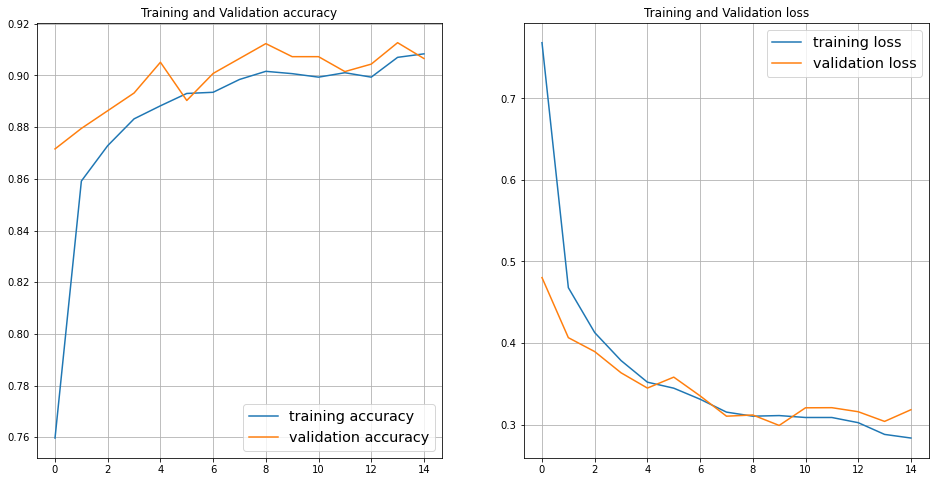

In [22]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
for idx, metric in enumerate(['accuracy', 'loss']):
    train_metric = hist[metric]
    val_metric   = hist[f'val_{metric}']
    
    plt.subplot(1, 2, idx+1)
    plt.plot(epochs_range, train_metric, label=f'training {metric}')
    plt.plot(epochs_range, val_metric, label=f'validation {metric}')
    plt.legend(fontsize='x-large');  plt.grid()
    plt.title(f'Training and Validation {metric}')
    
plt.show()

In [23]:
data_dir = join(PATH.INPUT, 'test')

img_arrays = []
names      = []
for path, name in sorted(list_files(data_dir), key=lambda e: int(''.join(filter(str.isdigit, e[1])))):
    img = keras.preprocessing.image.load_img(path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_arrays.append(img_array)
    names.append(name)
img_arrays = np.array(img_arrays)

predictions = model.predict(img_arrays)
predictions = np.argmax(predictions, axis=1)

sub = pd.DataFrame({'file_name': names, 'answer': predictions})
output_path = join(PATH.OUTPUT, f'{exp_name}.csv')
sub.to_csv(output_path, index=None)